In [1]:
import scipy.interpolate
from matplotlib import pyplot as plt
import numpy as np
import cv2
from math import log10, sqrt

In [2]:
def SP(bits, dataCarriers):
    return bits.reshape((len(dataCarriers), mu))

In [3]:
def Mapping(bits):
    return np.array([mapping_table[tuple(b)] for b in bits])

In [4]:
def OFDM_symbol(QAM_payload, K, pilotCarriers, dataCarriers):
    symbol = np.zeros(K, dtype=complex) # the overall K subcarriers
    symbol[pilotCarriers] = pilotValue  # allocate the pilot subcarriers 
    symbol[dataCarriers] = QAM_payload  # allocate the pilot subcarriers
    return symbol

In [5]:
def IDFT(OFDM_data):
    return np.fft.ifft(OFDM_data)

In [6]:
def addCP(OFDM_time, CP):
    cp = OFDM_time[-CP:]               # take the last CP samples ...
    return np.hstack([cp, OFDM_time])  # ... and add them to the beginning

In [7]:
def channel(signal):
    convolved = np.convolve(signal, channelResponse)
    signal_power = np.mean(abs(convolved**2))
    sigma2 = signal_power * 10**(-SNRdb/10)  # calculate noise power based on signal power and SNR
    
    #print ("RX Signal power: %.4f. Noise power: %.4f" % (signal_power, sigma2))
    
    # Generate complex noise with given variance
    noise = np.sqrt(sigma2/2) * (np.random.randn(*convolved.shape)+1j*np.random.randn(*convolved.shape))
    return convolved + noise

In [8]:
def removeCP(signal, CP, K):
    return signal[CP:(CP+K)]

In [9]:
def DFT(OFDM_RX):
    return np.fft.fft(OFDM_RX)

In [10]:
def channelEstimate(OFDM_demod, pilotCarriers, allCarriers):
    pilots = OFDM_demod[pilotCarriers]  # extract the pilot values from the RX signal
    Hest_at_pilots = pilots / pilotValue # divide by the transmitted pilot values
    
    # Perform interpolation between the pilot carriers to get an estimate
    # of the channel in the data carriers. Here, we interpolate absolute value and phase 
    # separately
    Hest_abs = scipy.interpolate.interp1d(pilotCarriers, abs(Hest_at_pilots), kind='linear')(allCarriers)
    Hest_phase = scipy.interpolate.interp1d(pilotCarriers, np.angle(Hest_at_pilots), kind='linear')(allCarriers)
    Hest = Hest_abs * np.exp(1j*Hest_phase)
    
    return Hest

In [11]:
def equalize(OFDM_demod, Hest):
    return OFDM_demod / Hest

In [12]:
def get_payload(equalized, dataCarriers):
    return equalized[dataCarriers]

In [13]:
def Demapping(QAM):
    # array of possible constellation points
    constellation = np.array([x for x in demapping_table.keys()])
    
    # calculate distance of each RX point to each possible point
    dists = abs(QAM.reshape((-1,1)) - constellation.reshape((1,-1)))
    
    # for each element in QAM, choose the index in constellation 
    # that belongs to the nearest constellation point
    const_index = dists.argmin(axis=1)
    
    # get back the real constellation point
    hardDecision = constellation[const_index]
    
    # transform the constellation point into the bit groups
    return np.vstack([demapping_table[C] for C in hardDecision]), hardDecision

In [14]:
def PS(bits):
    return bits.reshape((-1,))

In [15]:
def data_transmit(bits):
    #K = 400521 # number of OFDM subcarriers
    # print("number of symbols:  ", len(bits)/4)
    K = int(len(bits)/4 + 9)
    CP = K//4  # length of the cyclic prefix: 25% of the block
    P = 8
    allCarriers = np.arange(K)  # indices of all subcarriers ([0, 1, ... K-1])
    pilotCarriers = allCarriers[::K//P] # Pilots is every (K/P)th carrier.
    # For convenience of channel estimation, let's make the last carriers also be a pilot
    pilotCarriers = np.hstack([pilotCarriers, np.array([allCarriers[-1]])])
    P = P+1
    dataCarriers = np.delete(allCarriers, pilotCarriers)
    # print ("allCarriers:   %s" % allCarriers)
    # print ("pilotCarriers: %s" % pilotCarriers)
    # print ("dataCarriers:  %s" % dataCarriers)
    
    bits_SP = SP(bits, dataCarriers)
    # print ("First 5 bit groups")
    # print (bits_SP[:5,:])

    QAM = Mapping(bits_SP)
    # print ("First 5 QAM symbols and bits:")
    # print (bits_SP[:5,:])
    # print (QAM[:5])

    OFDM_data = OFDM_symbol(QAM, K, pilotCarriers, dataCarriers)
    # print ("Number of OFDM sub carriers in frequency domain: ", len(OFDM_data))

    OFDM_time = IDFT(OFDM_data)
    # print ("Number of OFDM samples in time-domain before CP: ", len(OFDM_time))

    OFDM_withCP = addCP(OFDM_time, CP)
    # print ("Number of OFDM samples in time domain with CP: ", len(OFDM_withCP))

    OFDM_TX = OFDM_withCP
    OFDM_RX = channel(OFDM_TX)

    OFDM_RX_noCP = removeCP(OFDM_RX, CP, K)
    OFDM_demod = DFT(OFDM_RX_noCP)

    Hest = channelEstimate(OFDM_demod, pilotCarriers, allCarriers)
    equalized_Hest = equalize(OFDM_demod, Hest)
    QAM_est = get_payload(equalized_Hest, dataCarriers)

    PS_est, hardDecision = Demapping(QAM_est)
    bits_est = PS(PS_est)
    # print(bits_est)
    # print(len(bits_est))
    # print ("Obtained Bit error rate: ", np.sum(abs(bits-bits_est))/len(bits))

    recei_image = []
    k = 0
    pixel_rec = ""
    for bit_rec in bits_est:
        pixel_rec = pixel_rec + str(bit_rec)
        k = k + 1
        if k == 8:
            recei_image.append(int(pixel_rec,2))
            pixel_rec = ""
            k = 0
    rec_image = np.asanyarray(recei_image, dtype=np.uint8)
    return rec_image
    # rec_image = np.reshape(rec_image, (576,768))
    # print(type(rec_image[1][1]))
    # print(rec_image)
    # cv2.imshow("xx", rec_image)
    # cv2.waitKey()

In [16]:
def PSNR(original, compressed): 
    mse = np.mean((original - compressed) ** 2) 
    if(mse == 0):  # MSE is zero means no noise is present in the signal . 
                  # Therefore PSNR have no importance. 
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse)) 
    return psnr

In [17]:
def channel_image(image_trans):
    # print(image_trans.shape)
    # print(image_trans)
    binary_image = []
    binary_image = np.array(binary_image)
    k = 0
    for i in image_trans:
        x = np.array([bin(k)[2:].zfill(8) for k in i])
        binary_row = []
        for pixel in x:
            for bit in pixel:
                binary_row.append(int(bit))
        bits = np.array(binary_row)
        if k == 0:
            binary_image = data_transmit(bits)
        else:
            binary_image = np.vstack((binary_image,data_transmit(bits)))
        k = k + 1
    # print((binary_image.shape))
    return binary_image

In [18]:
def main():
    image_trans = cv2.imread("cc96e68f4f452769d75d656ca65c1f1c.jpg")
    image_trans = np.asanyarray(image_trans)
    print(image_trans.shape, "   : image trans shape")
    blue, green, red = image_trans[:,:,0], image_trans[:,:, 1], image_trans[:,:,2]
  
    blue_trans = channel_image(blue)
    green_trans = channel_image(green)
    red_trans = channel_image(red)

    rgb_trans = np.dstack((blue_trans, green_trans, red_trans))

    value = PSNR(image_trans, rgb_trans) 
    print("SNR value is: ", SNRdb)
    print("PSNR value is:  ", str(round(value, 2)), " dB") 
    #cv2.imshow("image_trans", rgb_trans)
    plt.imshow(rgb_trans)
    plt.title('image trans')
    plt.show()
    #cv2.waitKey()

(314, 236, 3)    : image trans shape
SNR value is:  10
PSNR value is:   35.84  dB


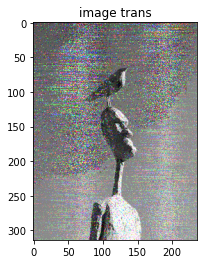

In [19]:
if __name__ == "__main__":
    mu = 4 # bits per symbol (i.e. 16QAM)
    mapping_table = {
        (0,0,0,0) : -3-3j,
        (0,0,0,1) : -3-1j,
        (0,0,1,0) : -3+3j,
        (0,0,1,1) : -3+1j,
        (0,1,0,0) : -1-3j,
        (0,1,0,1) : -1-1j,
        (0,1,1,0) : -1+3j,
        (0,1,1,1) : -1+1j,
        (1,0,0,0) :  3-3j,
        (1,0,0,1) :  3-1j,
        (1,0,1,0) :  3+3j,
        (1,0,1,1) :  3+1j,
        (1,1,0,0) :  1-3j,
        (1,1,0,1) :  1-1j,
        (1,1,1,0) :  1+3j,
        (1,1,1,1) :  1+1j
    }
    demapping_table = {v : k for k, v in mapping_table.items()}

    channelResponse = np.array([1, 0, 0.3+0.3j])  # the impulse response of the wireless channel
    SNRdb = 10  # signal to noise-ratio in dB at the receiver 
    pilotValue = 3+3j # The known value each pilot transmits
    main()